# Dependecies

In [2]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D

sns.set_style("whitegrid")

# Load stats (Retina)

In [6]:
models_dir = "models/retina"
json_files = []

for model_name in os.listdir(models_dir):
    model_dir = os.path.join(models_dir, model_name)
    if os.path.isdir(model_dir):
        stats_dir = os.path.join(model_dir, 'stats')
        if '.ipynb_checkpoints' in stats_dir:
            continue
        for file in os.listdir(stats_dir):
            if file.endswith('.json'):
                json_files.append(os.path.join(stats_dir, file))

json_files

['models/retina/unet/stats/unet_24_adam_bce_total_variation_augmented.json',
 'models/retina/unet/stats/unet_24_adam_dice_loss.json',
 'models/retina/unet/stats/unet_24_adam_bce_loss.json',
 'models/retina/unet/stats/unet_24_adam_bce_loss_augmented.json',
 'models/retina/unet/stats/unet_24_adam_bce_total_variation.json',
 'models/retina/unet/stats/unet_24_adam_dice_loss_augmented.json',
 'models/retina/cnn/stats/cnn_24_adam_bce_total_variation_augmented.json',
 'models/retina/cnn/stats/cnn_24_adam_bce_total_variation.json',
 'models/retina/cnn/stats/cnn_24_adam_dice_loss_augmented.json',
 'models/retina/cnn/stats/cnn_24_adam_bce_loss_augmented.json',
 'models/retina/cnn/stats/cnn_24_adam_dice_loss.json',
 'models/retina/cnn/stats/cnn_24_adam_bce_loss.json']

In [7]:
stats_list = []
for fname in json_files:
    with open(fname, 'r') as f:
        stats_list.append(json.load(f))

In [54]:
stats_list_cnn = [stat for stat in stats_list if stat['model'] == 'cnn']
stats_list_unet = [stat for stat in stats_list if stat['model'] == 'unet']

In [87]:
import matplotlib.cm as cm

def stat_to_setting(stat):
    if stat['loss_function'] == 'bce_total_variation':
        return 0 if stat['data_augmentation'] else 1
    elif stat['loss_function'] == 'dice_loss':
        return 2 if stat['data_augmentation'] else 3
    elif stat['loss_function'] == 'bce_loss':
        return 4 if stat['data_augmentation'] else 5
    else:
        raise ValueError(f"Unrecognized model settings: {stat}")

setting_colormap = cm.get_cmap('tab10', 6)
stat2color = lambda stat: setting_colormap(stat_to_setting(stat))

/var/folders/w8/wb7dt4yd6ys326nsmh5q64200000gn/T/ipykernel_1527/910064873.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  setting_colormap = cm.get_cmap('tab10', 6)


/var/folders/w8/wb7dt4yd6ys326nsmh5q64200000gn/T/ipykernel_1527/3645150844.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap('tab10')


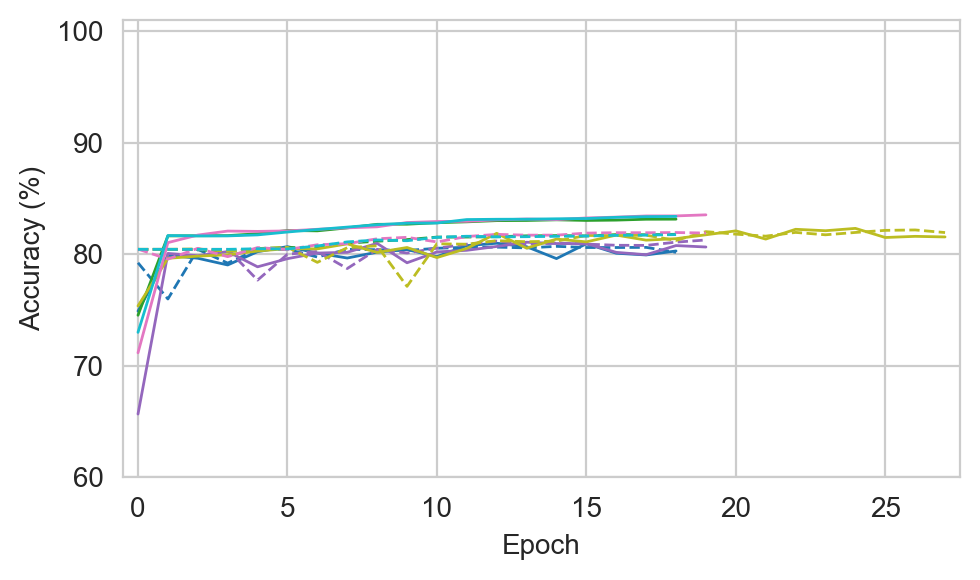

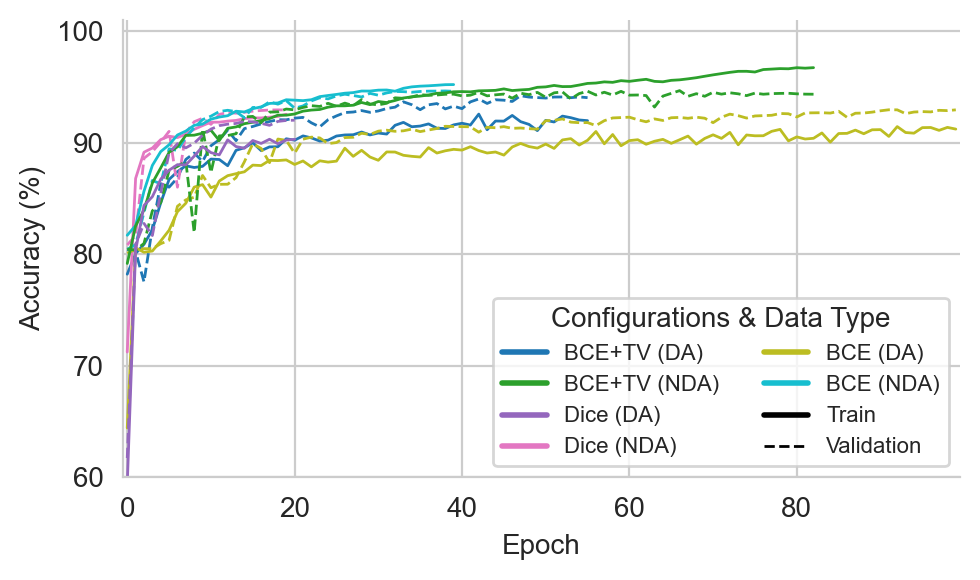

In [113]:
import matplotlib as mpl

# Generate a color map with distinct colors for different configurations
colors = mpl.cm.get_cmap('tab10')

configurations = ['BCE+TV (DA)', 'BCE+TV (NDA)', 'Dice (DA)', 'Dice (NDA)', 'BCE (DA)', 'BCE (NDA)']

# CNN Plot
fig1, ax1 = plt.subplots(figsize=(5, 3), tight_layout=True, dpi=200)
max_epoch_cnn = 0
for i, stat in enumerate(stats_list_cnn):
    color = colors(i)

    ax1.plot(np.array(stat['train_acc']) * 100, color=stat2color(stat), linewidth=1)
    ax1.plot(np.array(stat['val_acc']) * 100, color=stat2color(stat), linestyle='dashed', linewidth=1)
    
    max_epoch_cnn = max(stat['epoch'][-1], max_epoch_cnn)

ax1.set_xlim((-.5, max_epoch_cnn + .5))
ax1.set_ylim((60, 101))
ax1.set_ylabel('Accuracy (%)')
ax1.set_xlabel('Epoch')

# UNet Plot
fig2, ax2 = plt.subplots(figsize=(5, 3), tight_layout=True, dpi=200)
max_epoch_unet = 0
for i, stat in enumerate(stats_list_unet):
    color = colors(i)

    ax2.plot(np.array(stat['train_acc']) * 100, color=stat2color(stat), linewidth=1)
    ax2.plot(np.array(stat['val_acc']) * 100, color=stat2color(stat), linestyle='dashed', linewidth=1)
    
    max_epoch_unet = max(stat['epoch'][-1], max_epoch_unet)

ax2.set_xlim((-.5, max_epoch_unet + .5))
ax2.set_ylim((60, 101))
ax2.set_ylabel('Accuracy (%)')
ax2.set_xlabel('Epoch')

# Legend for line colors and styles
color_legend = [Line2D([0], [0], color=setting_colormap(i), lw=2) for i in range(len(configurations))]
style_legend = [Line2D([0], [0], color='black', lw=2), Line2D([0], [0], color='black', lw=1, linestyle='dashed')]
legends = color_legend + style_legend
legend_labels = configurations + ['Train', 'Validation']

ax2.legend(legends, legend_labels, loc='lower right', title='Configurations & Data Type', ncol=2, prop={'size':8})

sns.despine(top=True, right=True)
plt.tight_layout()
fig1.savefig('figs/ablation_retina_cnn.png', bbox_inches='tight')
fig2.savefig('figs/ablation_retina_unet.png', bbox_inches='tight')


# Test metrics
The following is the estimated performance on the test set of the best performing CNN and UNet model:

In [117]:
max_val_accuracy_cnn = 0
max_val_model_cnn = None

for stat in stats_list_cnn:
    if max(stat['val_acc']) > max_val_accuracy_cnn:
        max_val_accuracy_cnn = max(stat['val_acc'])
        max_val_model_cnn = stat

print(f"Model with highest validation accuracy for CNN: {max_val_model_cnn['loss_function']}, DA:{max_val_model_cnn['data_augmentation']} with accuracy {max_val_accuracy_cnn*100}%")


max_val_accuracy_unet = 0
max_val_model_unet = None

for stat in stats_list_unet:
    if max(stat['val_acc']) > max_val_accuracy_unet:
        max_val_accuracy_unet = max(stat['val_acc'])
        max_val_model_unet = stat

print(f"Model with highest validation accuracy for UNet: {max_val_model_unet['loss_function']}, DA:{max_val_model_unet['data_augmentation']} with accuracy {max_val_accuracy_unet*100}%")



Model with highest validation accuracy for CNN: bce_loss, DA:True with accuracy 82.18255639076233%
Model with highest validation accuracy for UNet: bce_total_variation, DA:False with accuracy 94.66989636421204%


Performance table

In [124]:
import pandas as pd
from tabulate import tabulate

# Metrics to include in the table
metrics = ['jaccard', 'dice', 'accuracy', 'precision', 'recall', 'specificity']

# Initialize a dictionary to store the performance metrics of each model
performance_metrics = {'Model': []}

for metric in metrics:
    performance_metrics[f'{metric} (mean ± CI)'] = []

# Models to compare
models = [max_val_model_cnn, max_val_model_unet]

for model in models:
    performance_metrics['Model'].append(model['model'])

    for metric in metrics:
        mean = model[metric]['mean']
        ci = model[metric]['conf_interval']
        performance_metrics[f'{metric} (mean ± CI)'].append(f'{mean:.3f} ± {ci:.3f}')

# Convert the dictionary to a DataFrame
df = pd.DataFrame(performance_metrics)

# Print the DataFrame as a pretty table
print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

+---------+-----------------------+--------------------+------------------------+-------------------------+----------------------+---------------------------+
| Model   | jaccard (mean ± CI)   | dice (mean ± CI)   | accuracy (mean ± CI)   | precision (mean ± CI)   | recall (mean ± CI)   | specificity (mean ± CI)   |
|---------+-----------------------+--------------------+------------------------+-------------------------+----------------------+---------------------------|
| cnn     | 0.694 ± 0.025         | 0.819 ± 0.017      | 0.819 ± 0.017          | 0.570 ± 0.032           | 0.322 ± 0.001        | 0.940 ± 0.012             |
| unet    | 0.893 ± 0.000         | 0.943 ± 0.000      | 0.943 ± 0.000          | 0.878 ± 0.002           | 0.825 ± 0.025        | 0.972 ± 0.004             |
+---------+-----------------------+--------------------+------------------------+-------------------------+----------------------+---------------------------+


In [125]:
# Convert the DataFrame to LaTeX
latex_table = df.to_latex(index=False)

# Make the best performance bold
for metric in metrics:
    # Find the best performance
    best_performance = max(df[f'{metric} (mean ± CI)'], key=lambda x: float(x.split(' ± ')[0]))
    
    # Make the best performance bold in the LaTeX table
    latex_table = latex_table.replace(best_performance, '\\textbf{' + best_performance + '}')

print(latex_table)

\begin{tabular}{lllllll}
\toprule
Model & jaccard (mean ± CI) & dice (mean ± CI) & accuracy (mean ± CI) & precision (mean ± CI) & recall (mean ± CI) & specificity (mean ± CI) \\
\midrule
  cnn &       0.694 ± 0.025 &    0.819 ± 0.017 &        0.819 ± 0.017 &         0.570 ± 0.032 &      0.322 ± 0.001 &           0.940 ± 0.012 \\
 unet &       \textbf{0.893 ± 0.000} &    \textbf{\textbf{0.943 ± 0.000}} &        \textbf{\textbf{0.943 ± 0.000}} &         \textbf{0.878 ± 0.002} &      \textbf{0.825 ± 0.025} &           \textbf{0.972 ± 0.004} \\
\bottomrule
\end{tabular}



/var/folders/w8/wb7dt4yd6ys326nsmh5q64200000gn/T/ipykernel_1527/3091276392.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df.to_latex(index=False)


In [129]:
max_val_model_cnn['model_name'], max_val_model_unet['model_name']

('cnn_24_adam_bce_loss_augmented', 'unet_24_adam_bce_total_variation')